# Where to open up a sushi restaurant in Skåne county, Sweden?


# Applied Data Science Capstone IBM / Coursera


## Import the necessary libraries

In [138]:
import pandas as pd
import numpy as np
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import beautifulsoup
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


# 1. Use web scraping with 'beautifulsoup' to gather the names of the different districts in Lund, Malmö and Helsingborg, and create a dataframe of this.

## Districts in Malmö

In [260]:
# Districts in Malmö
# https://sv.wikipedia.org/wiki/Malm%C3%B6_kommun#Stadsomr%C3%A5den
# Väster, Innerstaden, Norr, Söder, Öster

url = 'https://sv.wikipedia.org/wiki/Malm%C3%B6_kommun#Stadsomr%C3%A5den'
res = requests.get(url) 
soup = BeautifulSoup(res.content,'lxml') # get the content from the website
# print(soup.prettify())

table = soup.find_all('ul')[6] # find the place where the districts are listed

values = []
for link in table.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
#print(values)

districtsmalmo = pd.DataFrame(values, columns=["District"]) # create the dataframe from the list
districtsmalmo['City'] = ['Malmo']*19 # add city name
districtsmalmo['District'] = districtsmalmo['District'].map(lambda x: x.lstrip('Malmö').rstrip('distrikt')) # remove unnecessary string
districtsmalmo.iloc[11] = ["Möllevången", "Malmo"]
districtsmalmo.head()

,District,City
0,Bunkeflo,Malmo
1,Eriksfälts,Malmo
2,Fosie,Malmo
3,Husie,Malmo
4,Hyllie,Malmo


## Districts in Lund

In [261]:
# Districts in Lund
# http://kartor.lund.se/wiki/lundanamn/index.php/Omr%C3%A5desindelning

url = 'http://kartor.lund.se/wiki/lundanamn/index.php/Omr%C3%A5desindelning'
res = requests.get(url) 
soup = BeautifulSoup(res.content,'lxml') # get the content from the website
# print(soup.prettify())

# Because of how the website listed the districts I have to do this in a couple of lines
centrum = soup.find_all('ul')[1] 
vaster = soup.find_all('ul')[3] 
norr = soup.find_all('ul')[5] 
oster = soup.find_all('ul')[7] 
soder = soup.find_all('ul')[9] 

values = []
for link in centrum.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
for link in vaster.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
for link in norr.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
for link in oster.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
for link in soder.find_all('a'):
    title = link.get("title")
    if title:
        values.append(title)
# print(values)

districtslund = pd.DataFrame(values, columns=["District"]) # create the dataframe from the list
districtslund['City'] = ['Lund']*29 # add city name
districtslund.District.replace('Norränga (sidan existerar inte)','Norränga', inplace=True) # replace unnecessary comment
districtslund.head()


,District,City
0,Stadskärnan,Lund
1,Norra innerstaden,Lund
2,Södra innerstaden,Lund
3,Professorsstaden,Lund
4,Gunnesbo,Lund


## Districts in Helsingborg

In [262]:
# Districts in Helsingborg
# https://en.wikipedia.org/wiki/Helsingborg#Subdivisions

url = 'https://en.wikipedia.org/wiki/Helsingborg#Subdivisions'
res = requests.get(url) 
soup = BeautifulSoup(res.content,'lxml') # get the content from the website
# print(soup.prettify())

table = soup.find_all('table',{'class':'wikitable'})[1] # find the table on the website
table_rows = table.find_all('tr') # extract the rows of the column from the table

values = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        values.append(row) # extra the rows and columns and put the text in an empty list

# the data comes back in different columns, so have to reorganize so it will be a dataframe with 2 columns again
df = pd.DataFrame(values, columns=["No.", "District", "1", "2", "3", "4"]) # create the dataframe from the list
df2 = df[['1','2']].rename(columns={"1": "No.", "2": "District"}) 
df3 = df[['3','4']].rename(columns={"3": "No.", "4": "District"})
df1 = df.drop(columns = ['1','2','3','4'])
districtshelsingborg = df1.append(df2).append(df3)
districtshelsingborg = districtshelsingborg.dropna().drop(columns= ['No.']).reset_index().drop(columns = ['index'])
districtshelsingborg['City'] = ['Helsingborg']*31 # add city name
districtshelsingborg['District'] = districtshelsingborg['District'].str.split(r'(').str.get(0) # remove unnecessary comments
districtshelsingborg.head()

,District,City
0,Norr,Helsingborg
1,Mariastaden,Helsingborg
2,Ringstorp,Helsingborg
3,Berga,Helsingborg
4,Drottninghög,Helsingborg


## Combine the districts into one dataframe

In [264]:
data = districtshelsingborg.append(districtslund).append(districtsmalmo).reset_index().drop(columns = ['index'])
data.to_csv('~/Desktop/projects/CourseraCapstone/districtsskane.csv')
data['DistrictCity'] = data[['District', 'City']].agg(','.join, axis=1)
data.head()

,District,City,DistrictCity
0,Norr,Helsingborg,"Norr ,Helsingborg"
1,Mariastaden,Helsingborg,"Mariastaden ,Helsingborg"
2,Ringstorp,Helsingborg,"Ringstorp ,Helsingborg"
3,Berga,Helsingborg,"Berga ,Helsingborg"
4,Drottninghög,Helsingborg,"Drottninghög ,Helsingborg"


# 2. Use 'geocoders' to get the coordinates of the different districts in Lund, Malmö and Helsingborg and create a dataframe of this

In [265]:

geolocator = Nominatim(user_agent="lund_explorer")
addresses = data['DistrictCity']

lat_lng = []

for address in addresses[:79]:
  g = geolocator.geocode(address, timeout=100)

  if g is None:
    print ('{} could not be geocoded'.format(address))
  else:
    print(g.address)
    print((g.latitude, g.longitude))
    lat_lng.append((g.latitude, g.longitude))
    
    




Norr, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.06871005, 12.657141983349742)
Mariastaden, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.084372650000006, 12.700611887795695)
Ringstorp, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.0690252, 12.6983054547402)
Berga, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.0755325, 12.721531051841055)
Drottninghög, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.0644187, 12.723693284232723)
Dalhem, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.06745135, 12.750838485414338)
Tågaborg S, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.05573295, 12.695004920238874)
Stattena, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.06016475, 12.698516175546985)
Fredriksdal, Helsingborg, Helsingborgs kommun, Skåne län, Götaland, Sverige
(56.05753395, 12.726913906573895)
Slottshöjden, Helsingborg, Hels

Slottsstadens skola, John Ericssons väg, Dammfri, Innerstaden, Malmö, Malmö kommun, Skåne län, Götaland, 21772, Sverige
(55.59195495, 12.966911728088267)
Sofielunds Industriområde, Innerstaden, Malmö, Malmö kommun, Skåne län, Götaland, 21444, Sverige
(55.5856184, 13.02431505824287)
Malmö City GK, Kvarnbybanan, Sallerups byväg, Södra Sallerup, Öster, Malmö kommun, Skåne län, Götaland, 21291, Sverige
(55.581473, 13.107397252853147)
Väster, Tygelsjö, Malmö kommun, Skåne län, Götaland, 21871, Sverige
(55.5146694, 13.0017156)
Västra Klagstorps kyrka, Gamla Borrebackevägen, Västra Klagstorp, Väster, Västra Klagstorp, Malmö kommun, Skåne län, Götaland, 21873, Sverige
(55.52815475, 12.994728504255326)
Västra Skrävlinge, Amiralsgatan, Höja, Öster, Malmö, Malmö kommun, Skåne län, Götaland, 212 34, Sverige
(55.5806678, 13.0601598)


In [266]:
# Combine the coordinates in a dataframe
# data = {'Latitude': [locationLund.latitude , locationMalmo.latitude, locationHelsingborg.latitude], 'Longitude' : [locationLund.longitude, locationMalmo.longitude, locationHelsingborg.longitude]}
df = pd.DataFrame(lat_lng)
df = pd.concat([data, df], axis=1)
df.columns = ['District', 'City', 'DistrictCity', 'Latitude', 'Longitude']

# there are some values that are a bit off after looking at the map. So I've looked them up and will change them to the correct values
df.iloc[0,3:5] = [56.056944, 12.683333]
df.iloc[28,3:5] = [56.011667, 12.7275]
df.iloc[11,3:5] = [56.0458, 12.6964]
df.iloc[24,3:5] = [56.027222, 12.708056]
df.iloc[18,3:5] = [56.038056, 12.703333]
df.head(30)
# norr 56.056944, 12.683333
# hogasten 56.011667, 12.7275
# centrum 56.0458, 12.6964
# planteringen 56.027222, 12.708056
# soder 56.038056, 12.703333

,District,City,DistrictCity,Latitude,Longitude
0,Norr,Helsingborg,"Norr ,Helsingborg",56.056944,12.683333
1,Mariastaden,Helsingborg,"Mariastaden ,Helsingborg",56.084373,12.700612
2,Ringstorp,Helsingborg,"Ringstorp ,Helsingborg",56.069025,12.698305
3,Berga,Helsingborg,"Berga ,Helsingborg",56.075533,12.721531
4,Drottninghög,Helsingborg,"Drottninghög ,Helsingborg",56.064419,12.723693
5,Dalhem,Helsingborg,"Dalhem ,Helsingborg",56.067451,12.750838
6,Tågaborg,Helsingborg,"Tågaborg ,Helsingborg",56.055733,12.695005
7,Stattena,Helsingborg,"Stattena ,Helsingborg",56.060165,12.698516
8,Fredriksdal,Helsingborg,"Fredriksdal ,Helsingborg",56.057534,12.726914
9,Slottshöjden,Helsingborg,"Slottshöjden ,Helsingborg",56.051651,12.696948


# 3. Use the 'explore' function in Foursquare API to extract information about venues within each district in Lund, Malmö and Helsingborg

In [268]:
CLIENT_ID = 'DVJ0NVC1TT1T5KW3SVRLEMVKZEA2CASMQMATEAJBGFK0R4NN' # your Foursquare ID
CLIENT_SECRET = 'JALT2YXMMJLH5TAQHWWOTPWVIWAWWTYCUJJCE0OFZVJGIZA2' # your Foursquare Secret
VERSION = '20180604'

In [124]:
radius = 750
limit = 100

# categoryId: Specify a categoryId (or include a list of comma-separated IDs if you want to select multiple categories) to limit the results to the specified category.
# food category: 4d4b7105d754a06374d81259
# japanese restaurant category: 4bf58dd8d48988d111941735
# sushi restaurant category: 4bf58dd8d48988d1d2941735

# define a function to get the different venues
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([venues for venue_list in venues_list for venues in venue_list])
    nearby_venues.columns = ['DistrictCity', 
                  'Latitude', 
                  'Longitude', 
                  'VenueName', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)



## Explore the restaurants in each district and create a dataframe of this.

In [274]:
category= '4d4b7105d754a06374d81259' # all restaurants

restaurant = getNearbyVenues(names = df['DistrictCity'],
                    latitudes = df['Latitude'],
                    longitudes = df['Longitude'])

In [378]:
#print(restaurant.shape) # 1008 results
restaurant[['District', 'City']] = pd.DataFrame(restaurant.DistrictCity.str.split(',', expand=True).values, ) # split the column in district and city
res = restaurant
res['Sushi'] = np.where(res['VenueCategory']=='Sushi Restaurant', 'Sushi', 'Other') # create a column for sushi or not sushi
res.head()


,DistrictCity,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory,District,City,Sushi
0,"Norr ,Helsingborg",56.056944,12.683333,Sillen & Makrillen,56.055801,12.680969,Seafood Restaurant,Norr,Helsingborg,Other
1,"Norr ,Helsingborg",56.056944,12.683333,Drottninggatan 35,56.052269,12.686810,Scandinavian Restaurant,Norr,Helsingborg,Other
2,"Norr ,Helsingborg",56.056944,12.683333,Nabo,56.054454,12.685131,Italian Restaurant,Norr,Helsingborg,Other
3,"Norr ,Helsingborg",56.056944,12.683333,VIA95,56.058408,12.682080,Scandinavian Restaurant,Norr,Helsingborg,Other
4,"Norr ,Helsingborg",56.056944,12.683333,Reko Sushi & Bowls,56.060018,12.689660,Sushi Restaurant,Norr,Helsingborg,Sushi


## Does each city hold roughly the same amount of restaurants?

<BarContainer object of 6 artists>

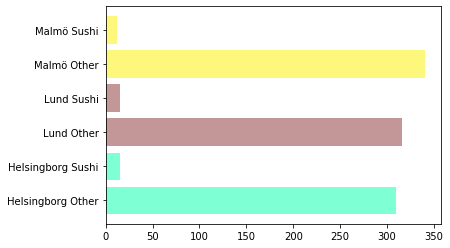

In [394]:
# How many restaurants are found in the different cities?
res[['City','Sushi','District']].groupby(['City', 'Sushi']).count()
plt.barh(y= ['Helsingborg Other', 'Helsingborg Sushi' , 'Lund Other','Lund Sushi', 'Malmö Other', 'Malmö Sushi'], width = [310, 15, 316, 15, 340, 12], color = ['#7fffd4','#7fffd4', '#c39797','#c39797', '#fdf77c', '#fdf77c'])
#plt.title('Number of restaurants in 3 cities in Skåne')

# 4. Visualize the locations of restaurants and sushi places in each city.

In [316]:
geolocator = Nominatim(user_agent="lund_explorer") # get the location of lund to center the map around there
g = geolocator.geocode('Lund, Sweden')

In [317]:
# create map of New York using latitude and longitude values
map_ = folium.Map(location=[g.latitude, g.longitude], zoom_start=10)

# slit res in sushi and other restaurants
sushi = res[res.Sushi == 'Sushi']
other = res[res.Sushi == 'Other']

# add markers to map for each district
for lat, lng, city, district in zip(df['Latitude'], df['Longitude'], df['City'], df['District']):
    label = '{}, {}'.format(city, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  

# add markers to map for each OTHER restaurant
for lat, lng, restaurant, city in zip(other['VenueLatitude'], other['VenueLongitude'], other['VenueCategory'], other['City']):
    label = '{}, {}'.format(restaurant, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#fdf77c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_) 
    
# add markers to map for each SUSHI restaurant
for lat, lng, restaurant, city in zip(sushi['VenueLatitude'], sushi['VenueLongitude'], sushi['VenueCategory'], sushi['City']):
    label = '{}, {}'.format(restaurant, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff7373',
        fill_opacity=0.8,
        parse_html=False).add_to(map_) 
    

map_

# 5. Analyze each district and use 'onehotencoding' to count frequencies of sushi restaurants and other restaurants.

In [319]:
# one hot encoding
skane = pd.get_dummies(res[['Sushi']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
skane['DistrictCity'] = res['DistrictCity'] 
skane['City'] = res['City']

skane.head()

skane2=skane.groupby('DistrictCity').sum().sort_values('Sushi',ascending=False)
skane2.head()

,Other,Sushi
DistrictCity,,
"Sankt Pauli ,Malmo",47,6
"Stadskärnan,Lund",72,4
"Västra innerstaden,Lund",42,3
"Centrum ,Helsingborg",60,3
"Slottshöjden ,Helsingborg",58,3


## Let's focus on districts with at least 1 other sushi restaurant. Which districts have restaurants, but relatively little sushi restaurants?

In [320]:
# don't consider neighbourhoods that have no sushi restaurants at all
skane3 = skane2[skane2.loc[:, 'Sushi'] != 0]
skane3['Percentage'] = round((skane3.loc[:, 'Sushi'] / skane3.loc[:, 'Other'])*100,2)
skane4 = skane3.sort_values('Percentage',ascending=True).reset_index()
skane4.head(25)

/Users/raissadeboer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,DistrictCity,Other,Sushi,Percentage
0,"Sankt Johannes ,Malmo",75,1,1.33
1,"Möllevången,Malmo",51,1,1.96
2,"Sankt Petri ,Malmo",80,2,2.50
3,"Södra innerstaden,Lund",36,1,2.78
4,"Professorsstaden,Lund",25,1,4.00
5,"Söder ,Helsingborg",23,1,4.35
6,"Norra universitetsområdet,Lund",21,1,4.76
7,"Ideon/Pålsjö,Lund",21,1,4.76
8,"Hyllie ,Malmo",20,1,5.00
9,"Centrum ,Helsingborg",60,3,5.00


## There are 23 districts to consider. Let's visualize the number of total restaurants and number of sushi restaurants with MatPlotLib.

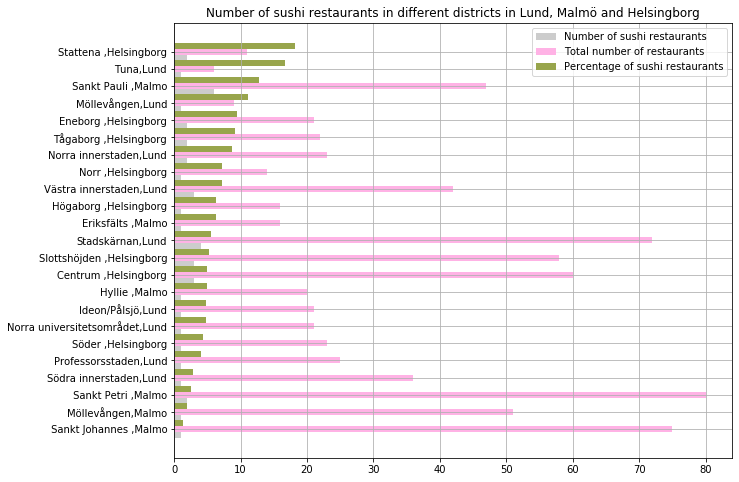

In [324]:
N=23
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,8))

width = 0.35

ax.barh(ind-width, skane4['Sushi'],width, color = '#cccccc', label = 'Number of sushi restaurants')
ax.barh(ind, skane4['Other'], width, color = '#ffb2e5', label = 'Total number of restaurants')
ax.barh(ind+width, skane4['Percentage'], width, color = '#98a54c', label = 'Percentage of sushi restaurants')
ax.set_yticks(ind)
ax.set_yticklabels(skane4['DistrictCity'])
ax.set_title('Number of sushi restaurants in different districts in Lund, Malmö and Helsingborg')
ax.legend()
ax.grid()

# 6. There are 23 districts that have at least one sushi restaurant and plenty of other restaurants. Let's explore these districts to see what other types of venues there are.

## Create a function to use the explore function in Foursquare API to obtain all venues in the 23 districts that we are considering.

In [326]:
radius = 750
limit = 100



def getAllVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([venues for venue_list in venues_list for venues in venue_list])
    nearby_venues.columns = ['DistrictCity', 
                  'Latitude', 
                  'Longitude', 
                  'VenueName', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)



## Create a dataframe with only the districts that have a sushi restaurant

In [328]:
# I want only the neighborhoods that we are considering (the districts which have sushi restaurants) in the dataframe skane 4
wanteddistricts = skane4['DistrictCity'].values

filter1 = df['DistrictCity'].isin(skane4['DistrictCity'])
df2 = df[filter1].reset_index()
df2 = df2.drop(columns="index")
df2.head()


,District,City,DistrictCity,Latitude,Longitude
0,Norr,Helsingborg,"Norr ,Helsingborg",56.056944,12.683333
1,Tågaborg,Helsingborg,"Tågaborg ,Helsingborg",56.055733,12.695005
2,Stattena,Helsingborg,"Stattena ,Helsingborg",56.060165,12.698516
3,Slottshöjden,Helsingborg,"Slottshöjden ,Helsingborg",56.051651,12.696948
4,Centrum,Helsingborg,"Centrum ,Helsingborg",56.045800,12.696400


## Obtain all venues in these districts and create a dataframe

In [329]:
# Use the explore functon to get all venues in the neighbourhoods
allvenues = getAllVenues(names = df2['DistrictCity'],
                    latitudes = df2['Latitude'],
                    longitudes = df2['Longitude'])

In [330]:
allvenues.head()

,DistrictCity,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,"Norr ,Helsingborg",56.056944,12.683333,Sillen & Makrillen,56.055801,12.680969,Seafood Restaurant
1,"Norr ,Helsingborg",56.056944,12.683333,Strandpromenaden,56.058967,12.681863,Beach
2,"Norr ,Helsingborg",56.056944,12.683333,Fria Bad,56.057980,12.681520,Beach
3,"Norr ,Helsingborg",56.056944,12.683333,Kallis,56.055456,12.681289,Spa
4,"Norr ,Helsingborg",56.056944,12.683333,Gröningen,56.052871,12.683829,Park


## Use 'onehotencoding' to make dummy variables of the venue categories

In [331]:
# one hot encoding
skane_onehot = pd.get_dummies(allvenues[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
skane_onehot['DistrictCity'] = allvenues['DistrictCity'] 

# move neighborhood column to the first column
fixed_columns = [skane_onehot.columns[-1]] + list(skane_onehot.columns[:-1])
skane_onehot = skane_onehot[fixed_columns]

skane_onehot.head()



,DistrictCity,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,...,Theater,Thrift / Vintage Store,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Zoo
0,"Norr ,Helsingborg",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Norr ,Helsingborg",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Norr ,Helsingborg",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Norr ,Helsingborg",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Norr ,Helsingborg",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Count the different venues in each district, group by district

In [213]:
# Group the data by district and reset the index
skane_grouped = skane_onehot.groupby('DistrictCity').sum().reset_index()
skane_grouped.head()

,DistrictCity,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Austrian Restaurant,Auto Garage,...,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Zoo
0,"Sankt Johannes ,Malmo",0,1,0,0,1,0,0,0,0,...,0,0,1,0,2,0,1,0,0,0
1,"Sankt Pauli ,Malmo",0,0,1,1,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
2,"Sankt Petri ,Malmo",0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,1,2,4,1,0
3,"Adolfsberg ,Helsingborg",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Berga ,Helsingborg",0,0,0,0,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0,0


## Arrange the dataframe so that we get the 10 most common venues in each district

In [239]:
# Create a function to return the most common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [240]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['DistrictCity']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['DistrictCity'] = skane_grouped['DistrictCity']

for ind in np.arange(skane_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(skane_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,DistrictCity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Sankt Johannes ,Malmo",Café,Scandinavian Restaurant,Indian Restaurant,Plaza,Park,Playground,Thrift / Vintage Store,Thai Restaurant,Italian Restaurant,Falafel Restaurant
1,"Sankt Pauli ,Malmo",Grocery Store,Sushi Restaurant,Bakery,Coffee Shop,Gym / Fitness Center,Pizza Place,Hot Dog Joint,Pub,Fast Food Restaurant,Middle Eastern Restaurant
2,"Sankt Petri ,Malmo",Hotel,Plaza,Wine Bar,Pub,Café,Coffee Shop,Bakery,Pizza Place,Burger Joint,Salad Place
3,"Adolfsberg ,Helsingborg",Business Service,Athletics & Sports,Thrift / Vintage Store,Soccer Field,Zoo,Farmers Market,French Restaurant,Fraternity House,Food Truck,Food Court
4,"Berga ,Helsingborg",Toy / Game Store,Hotel,Restaurant,Salad Place,Laundry Service,Kids Store,Gym / Fitness Center,Mexican Restaurant,Train Station,Health & Beauty Service


# 7. Let's do a cluster analysis to group the districts to get a sense of what types of districts there are and to see if we can find an indication of which districts are most suitable for a new sushi restaurant.

## In order to find the optimal number of clusters we can use the 'elbow' method. I plot the sum of squared error (SSE) for a range of clusters (1-10). The place where the SSE's stabilize, i.e. the 'elbow', is the optimal number of clusters.

In [345]:
SSE = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(skane_grouped_clustering)
    SSE.append(kmeanModel.inertia_)
    


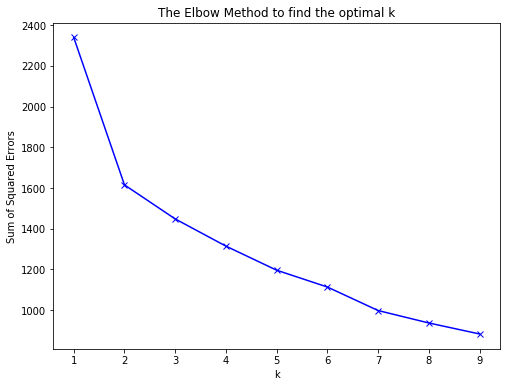

In [348]:
plt.figure(figsize=(8,6))
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.title('The Elbow Method to find the optimal k')
plt.show()

## Well, that's not a very helpful plot. There is no clear leveling off. So it seems that the districts are difficult to cluster. I'll pick 5 clusters, which is somewhere in the middle of the downward slope. Picking a higher amount of clusters kind of loses the point of clustering.

In [351]:
# set number of clusters
kclusters = 5

# create dataframe with only the venue categories
skane_grouped_clustering = skane_grouped.drop('DistrictCity', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(skane_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


array([4, 2, 0, 1, 1, 1, 1, 3, 1, 1], dtype=int32)

In [395]:
# merge data to add latitude/longitude for each neighborhood
df2_merged = df2.join(district_venues_sorted.set_index('DistrictCity'), on='DistrictCity')

df2_merged.head() # check the last columns!

df2_merged.loc[df2_merged['Cluster Labels'] == 0, df2_merged.columns[[1] + list(range(5, df2_merged.shape[1]))]]
df2_merged = df2_merged.reset_index().drop(columns="index")
df2_merged.head(23)

,District,City,DistrictCity,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Norr,Helsingborg,"Norr ,Helsingborg",56.056944,12.683333,2,Park,Scandinavian Restaurant,Pizza Place,Seafood Restaurant,Beach,Grocery Store,Italian Restaurant,Sushi Restaurant,Bakery,Golf Course
1,Tågaborg,Helsingborg,"Tågaborg ,Helsingborg",56.055733,12.695005,2,Pizza Place,Grocery Store,Italian Restaurant,Park,Plaza,Restaurant,Sushi Restaurant,Pub,Electronics Store,Candy Store
2,Stattena,Helsingborg,"Stattena ,Helsingborg",56.060165,12.698516,2,Pizza Place,Grocery Store,Gym / Fitness Center,Sushi Restaurant,Zoo,Sandwich Place,Candy Store,Thai Restaurant,Bakery,Pub
3,Slottshöjden,Helsingborg,"Slottshöjden ,Helsingborg",56.051651,12.696948,3,Pizza Place,Scandinavian Restaurant,Restaurant,Coffee Shop,Grocery Store,Café,Thai Restaurant,Park,Bar,Stadium
4,Centrum,Helsingborg,"Centrum ,Helsingborg",56.045800,12.696400,3,Hotel,Scandinavian Restaurant,Restaurant,Café,Bar,Coffee Shop,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
5,Eneborg,Helsingborg,"Eneborg ,Helsingborg",56.042541,12.709476,2,Bus Stop,Park,Hotel,Asian Restaurant,Grocery Store,Shopping Mall,Supermarket,Fast Food Restaurant,Restaurant,Smoke Shop
6,Söder,Helsingborg,"Söder ,Helsingborg",56.038056,12.703333,2,Hotel,Grocery Store,Park,Bus Stop,Supermarket,Convenience Store,Pizza Place,Diner,Plaza,Pub
7,Högaborg,Helsingborg,"Högaborg ,Helsingborg",56.039077,12.712439,2,Bus Stop,Park,Pizza Place,Grocery Store,Pub,Burger Joint,Shopping Mall,Smoke Shop,Fast Food Restaurant,Restaurant
8,Stadskärnan,Lund,"Stadskärnan,Lund",55.702654,13.193793,0,Café,Italian Restaurant,Asian Restaurant,Plaza,Pub,Coffee Shop,Park,Burger Joint,Fraternity House,Sushi Restaurant
9,Norra innerstaden,Lund,"Norra innerstaden,Lund",55.711064,13.195779,2,Scandinavian Restaurant,Café,Italian Restaurant,Asian Restaurant,Fraternity House,Pub,Park,Plaza,Cocktail Bar,Candy Store


## Can we assign a type of neighbourhood to the different clusters? Let's explore the clusters independently to see what type of venues are common.

In [401]:
# Let's examine the different clusters

df2_merged.loc[df2_merged['Cluster Labels'] == 0, df2_merged.columns[[0,1] + list(range(5, df2_merged.shape[1]))]]

,District,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Stadskärnan,Lund,0,Café,Italian Restaurant,Asian Restaurant,Plaza,Pub,Coffee Shop,Park,Burger Joint,Fraternity House,Sushi Restaurant
10,Södra innerstaden,Lund,0,Café,Italian Restaurant,Plaza,Supermarket,Restaurant,Bus Stop,Bakery,Pizza Place,Burger Joint,Grocery Store
12,Västra innerstaden,Lund,0,Café,Italian Restaurant,Plaza,Supermarket,Coffee Shop,Pub,Sushi Restaurant,Pizza Place,Hotel,Asian Restaurant
21,Sankt Petri,Malmo,0,Hotel,Plaza,Wine Bar,Pub,Café,Coffee Shop,Bakery,Pizza Place,Burger Joint,Salad Place


## Cluster 1: These districts have in common that they have a lot of cafes, pubs and wine bars. There are mainly italian restaurants. Let's call this cluster 'Italian/Bars'.

In [397]:
# Let's examine the different clusters

df2_merged.loc[df2_merged['Cluster Labels'] == 1, df2_merged.columns[[0, 1] + list(range(5, df2_merged.shape[1]))]]

,District,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Möllevången,Lund,1,Park,Fast Food Restaurant,Monument / Landmark,Scandinavian Restaurant,Thai Restaurant,Gym / Fitness Center,Diner,Restaurant,Convenience Store,Hotel


## Cluster 2: This cluster consists of only 1 district in Lund. It seems to be defined by a park with some type of monument. Let's call this 'Park'.

In [398]:
# Let's examine the different clusters

df2_merged.loc[df2_merged['Cluster Labels'] == 2, df2_merged.columns[[0,1] + list(range(5, df2_merged.shape[1]))]]

,District,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Norr,Helsingborg,2,Park,Scandinavian Restaurant,Pizza Place,Seafood Restaurant,Beach,Grocery Store,Italian Restaurant,Sushi Restaurant,Bakery,Golf Course
1,Tågaborg,Helsingborg,2,Pizza Place,Grocery Store,Italian Restaurant,Park,Plaza,Restaurant,Sushi Restaurant,Pub,Electronics Store,Candy Store
2,Stattena,Helsingborg,2,Pizza Place,Grocery Store,Gym / Fitness Center,Sushi Restaurant,Zoo,Sandwich Place,Candy Store,Thai Restaurant,Bakery,Pub
5,Eneborg,Helsingborg,2,Bus Stop,Park,Hotel,Asian Restaurant,Grocery Store,Shopping Mall,Supermarket,Fast Food Restaurant,Restaurant,Smoke Shop
6,Söder,Helsingborg,2,Hotel,Grocery Store,Park,Bus Stop,Supermarket,Convenience Store,Pizza Place,Diner,Plaza,Pub
7,Högaborg,Helsingborg,2,Bus Stop,Park,Pizza Place,Grocery Store,Pub,Burger Joint,Shopping Mall,Smoke Shop,Fast Food Restaurant,Restaurant
9,Norra innerstaden,Lund,2,Scandinavian Restaurant,Café,Italian Restaurant,Asian Restaurant,Fraternity House,Pub,Park,Plaza,Cocktail Bar,Candy Store
11,Professorsstaden,Lund,2,Park,Fraternity House,Asian Restaurant,Pizza Place,Steakhouse,Restaurant,Café,Scandinavian Restaurant,Bus Stop,Fast Food Restaurant
15,Norra universitetsområdet,Lund,2,Bus Stop,Café,Restaurant,Coffee Shop,Diner,Food Court,Fraternity House,Burger Joint,Breakfast Spot,Fast Food Restaurant
16,Tuna,Lund,2,Park,Café,Bus Stop,Hotel,Sushi Restaurant,Pizza Place,Convention Center,Diner,Coffee Shop,Fraternity House


## Cluster 3: Most of the districts fall within this cluster. It has a bit of everything, there is not a certain type of restaurant that stands out. There are parks, bus stops, coffee shops, clothing stores. Let's call this 'Diverse'.

In [399]:
# Let's examine the different clusters

df2_merged.loc[df2_merged['Cluster Labels'] == 3, df2_merged.columns[[0,1] + list(range(5, df2_merged.shape[1]))]]

,District,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Slottshöjden,Helsingborg,3,Pizza Place,Scandinavian Restaurant,Restaurant,Coffee Shop,Grocery Store,Café,Thai Restaurant,Park,Bar,Stadium
4,Centrum,Helsingborg,3,Hotel,Scandinavian Restaurant,Restaurant,Café,Bar,Coffee Shop,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
13,Ideon/Pålsjö,Lund,3,Restaurant,Bus Stop,Café,Hotel,Scandinavian Restaurant,Coffee Shop,Thai Restaurant,Supermarket,Gym,Breakfast Spot


## Cluster 4: Looks like these districts have in common to have a lot of scandinavian restaurants. There are plenty of other restaurants too. They also have Thai restaurants in common. Let's call this 'Scandinavian/Thai'

In [400]:
# Let's examine the different clusters

df2_merged.loc[df2_merged['Cluster Labels'] == 4, df2_merged.columns[[0,1] + list(range(5, df2_merged.shape[1]))]]

,District,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Sankt Johannes,Malmo,4,Café,Scandinavian Restaurant,Indian Restaurant,Plaza,Park,Playground,Thrift / Vintage Store,Thai Restaurant,Italian Restaurant,Falafel Restaurant
22,Möllevången,Malmo,4,Indian Restaurant,Scandinavian Restaurant,Restaurant,Café,Thrift / Vintage Store,Vietnamese Restaurant,Falafel Restaurant,Gym,Middle Eastern Restaurant,Plaza


## Cluster 5: This cluster is also characterized by a lot of Scandinavian restaurants, but also Indian restaurants. Let's call this 'Scandinavian/Indian'.

In [410]:
# Lets relabel the Cluster labels to hold information about the clusters.

labelnames = {0 : "Cluster 1: Italian/Bars", 1: "Cluster 2: Park", 2: "Cluster 3: Diverse", 3: "Cluster 4: Scandinavian/Thai", 4: "Cluster 5: Scandinavian/Indian"}
df2_merged['ClusterLabels'] = df2_merged['Cluster Labels'].map(labelnames)

df2_merged.head()

,District,City,DistrictCity,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,ClusterLabels
0,Norr,Helsingborg,"Norr ,Helsingborg",56.056944,12.683333,2,Park,Scandinavian Restaurant,Pizza Place,Seafood Restaurant,Beach,Grocery Store,Italian Restaurant,Sushi Restaurant,Bakery,Golf Course,Cluster 3: Diverse
1,Tågaborg,Helsingborg,"Tågaborg ,Helsingborg",56.055733,12.695005,2,Pizza Place,Grocery Store,Italian Restaurant,Park,Plaza,Restaurant,Sushi Restaurant,Pub,Electronics Store,Candy Store,Cluster 3: Diverse
2,Stattena,Helsingborg,"Stattena ,Helsingborg",56.060165,12.698516,2,Pizza Place,Grocery Store,Gym / Fitness Center,Sushi Restaurant,Zoo,Sandwich Place,Candy Store,Thai Restaurant,Bakery,Pub,Cluster 3: Diverse
3,Slottshöjden,Helsingborg,"Slottshöjden ,Helsingborg",56.051651,12.696948,3,Pizza Place,Scandinavian Restaurant,Restaurant,Coffee Shop,Grocery Store,Café,Thai Restaurant,Park,Bar,Stadium,Cluster 4: Scandinavian/Thai
4,Centrum,Helsingborg,"Centrum ,Helsingborg",56.045800,12.696400,3,Hotel,Scandinavian Restaurant,Restaurant,Café,Bar,Coffee Shop,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Cluster 4: Scandinavian/Thai


In [411]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, clusterstr in zip(df2_merged['Latitude'], df2_merged['Longitude'], df2_merged['DistrictCity'], df2_merged['Cluster Labels'], df2_merged['ClusterLabels']):
    label = '{},{}'.format(poi, clusterstr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# That's it, we now have the information to make an informed recommendation about where to open a new sushi restaurant.